# I. 모델 성능 테스트

In [1]:
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # warning 메시지 숨기기

import tensorflow as tf
print("Is GPU available:", tf.test.is_gpu_available())

import tensorflow as tf
print('tf.__version__:',tf.__version__)

2025-03-07 12:48:12.487879: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 12:48:12.538169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-07 12:48:13.361141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True
tf.__version__: 2.13.0


2025-03-07 12:48:14.372218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-07 12:48:14.381922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-07 12:48:14.383416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
tf.config.set_visible_devices([], 'GPU')

2025-03-07 12:48:17.931879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-07 12:48:17.933645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-07 12:48:17.935100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## 1. 원본 테스트 파일

### 1) V4 - ood 기준 샘플링 데이터 학습 모델

X_test shape: (2904, 50, 1)
91/91 [==============================] - 1s 7ms/step


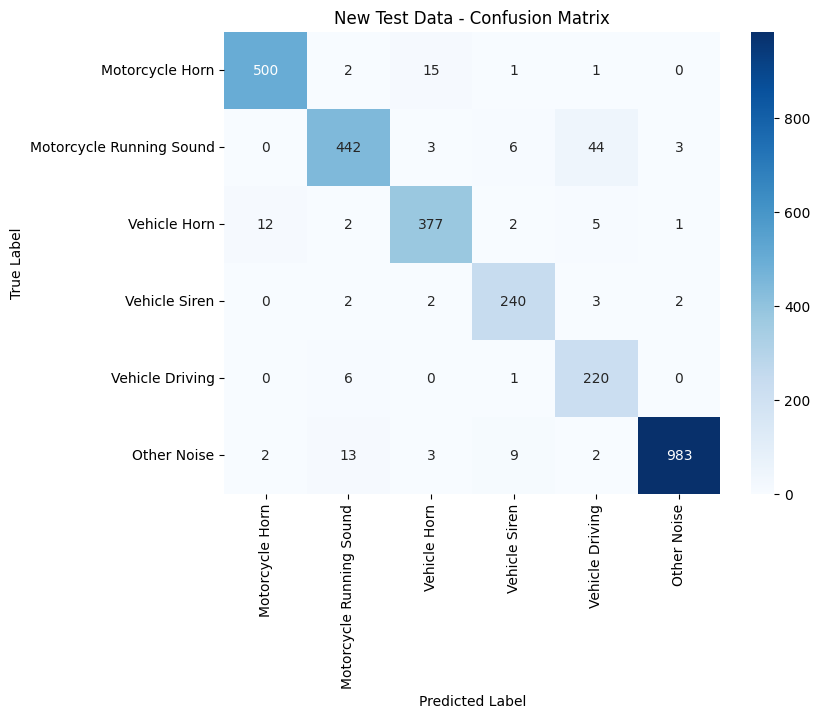


New Test Data Evaluation:
 Accuracy: 0.9511

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.97      0.96      0.97       519
Motorcycle Running Sound       0.95      0.89      0.92       498
            Vehicle Horn       0.94      0.94      0.94       399
           Vehicle Siren       0.93      0.96      0.94       249
         Vehicle Driving       0.80      0.97      0.88       227
             Other Noise       0.99      0.97      0.98      1012

                accuracy                           0.95      2904
               macro avg       0.93      0.95      0.94      2904
            weighted avg       0.95      0.95      0.95      2904


--- Sample Predictions ---
1/1 [==============================] - 0s 17ms/step
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [==============================] - 0s 17ms/step
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [========

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################################
# Part 0. 모델 로드 및 데이터 로드
#############################################
model_file = "resnet_model_modified_v4.h5"
test_file = "final_test_data_original.csv"  # 새로운 테스트 데이터 파일 경로를 여기에 입력하세요.

loaded_model = load_model(model_file)
test_df = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩 (학습 데이터와 동일한 라벨 매핑 사용)
#############################################
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

y_test = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 평가 함수 정의 및 적용 (영어 라벨 표시)
#############################################
def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels))
    return acc

# 평가: 테스트 데이터 평가
test_acc = evaluate_model(loaded_model, X_test, y_test, dataset_name="New Test Data")

#############################################
# Part 4. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(loaded_model.predict(X_test[i:i+1]))]
    conf = np.max(loaded_model.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")

### 2) V6 - category3 기준 샘플링 데이터 학습 모델

X_test shape: (2904, 50, 1)
91/91 [==============================] - 2s 14ms/step


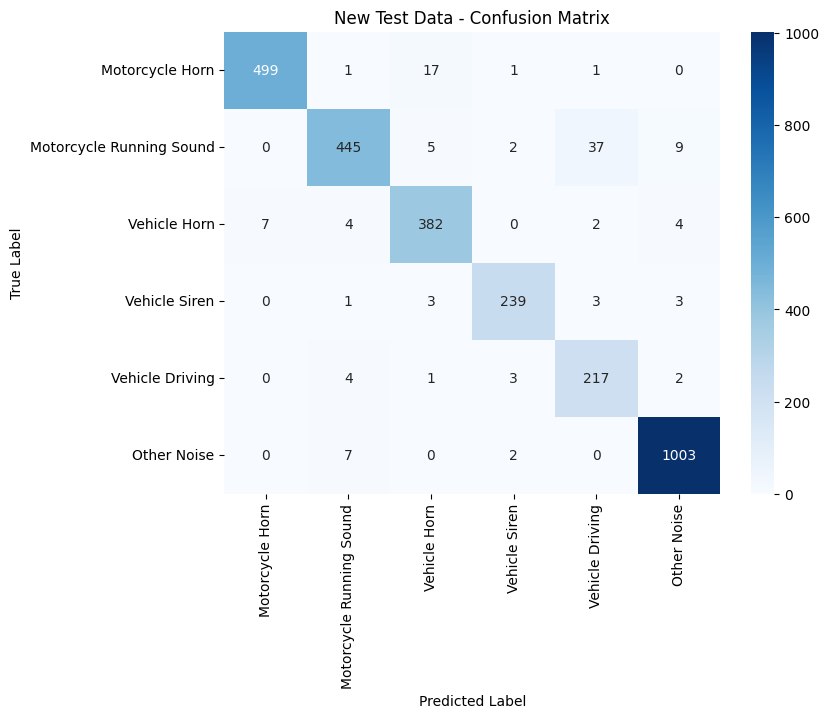


New Test Data Evaluation:
 Accuracy: 0.9590

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.99      0.96      0.97       519
Motorcycle Running Sound       0.96      0.89      0.93       498
            Vehicle Horn       0.94      0.96      0.95       399
           Vehicle Siren       0.97      0.96      0.96       249
         Vehicle Driving       0.83      0.96      0.89       227
             Other Noise       0.98      0.99      0.99      1012

                accuracy                           0.96      2904
               macro avg       0.95      0.95      0.95      2904
            weighted avg       0.96      0.96      0.96      2904


--- Sample Predictions ---
1/1 [==============================] - 0s 34ms/step
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [==============================] - 0s 29ms/step
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [========

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################################
# Part 0. 모델 로드 및 데이터 로드
#############################################
model_file = "resnet_model_modified_v6.h5"
test_file = "final_test_data_original.csv"  # 새로운 테스트 데이터 파일 경로를 여기에 입력하세요.

loaded_model = load_model(model_file)
test_df = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩 (학습 데이터와 동일한 라벨 매핑 사용)
#############################################
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

y_test = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 평가 함수 정의 및 적용 (영어 라벨 표시)
#############################################
def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels))
    return acc

# 평가: 테스트 데이터 평가
test_acc = evaluate_model(loaded_model, X_test, y_test, dataset_name="New Test Data")

#############################################
# Part 4. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(loaded_model.predict(X_test[i:i+1]))]
    conf = np.max(loaded_model.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")

### 3) V7 - 원본 데이터 학습 모델

X_test shape: (2904, 50, 1)
91/91 [==============================] - 1s 7ms/step


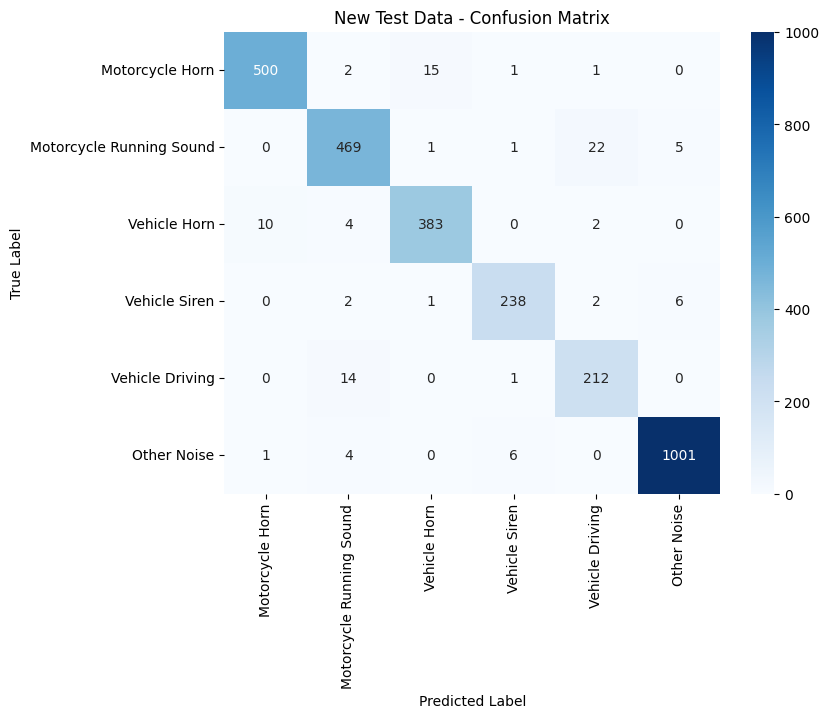


New Test Data Evaluation:
 Accuracy: 0.9652

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.98      0.96      0.97       519
Motorcycle Running Sound       0.95      0.94      0.94       498
            Vehicle Horn       0.96      0.96      0.96       399
           Vehicle Siren       0.96      0.96      0.96       249
         Vehicle Driving       0.89      0.93      0.91       227
             Other Noise       0.99      0.99      0.99      1012

                accuracy                           0.97      2904
               macro avg       0.95      0.96      0.96      2904
            weighted avg       0.97      0.97      0.97      2904


--- Sample Predictions ---
1/1 [==============================] - 0s 18ms/step
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [==============================] - 0s 18ms/step
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [========

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################################
# Part 0. 모델 로드 및 데이터 로드
#############################################
model_file = "resnet_model_modified_v7.h5"
test_file = "final_test_data_original.csv"  # 새로운 테스트 데이터 파일 경로를 여기에 입력하세요.

loaded_model = load_model(model_file)
test_df = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩 (학습 데이터와 동일한 라벨 매핑 사용)
#############################################
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

y_test = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 평가 함수 정의 및 적용 (영어 라벨 표시)
#############################################
def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels))
    return acc

# 평가: 테스트 데이터 평가
test_acc = evaluate_model(loaded_model, X_test, y_test, dataset_name="New Test Data")

#############################################
# Part 4. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(loaded_model.predict(X_test[i:i+1]))]
    conf = np.max(loaded_model.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")

## 2. category 03 샘플링 테스트 파일

### 1) V4 - ood 기준 샘플링 데이터 학습 모델

X_test shape: (990, 50, 1)
31/31 [==============================] - 1s 14ms/step


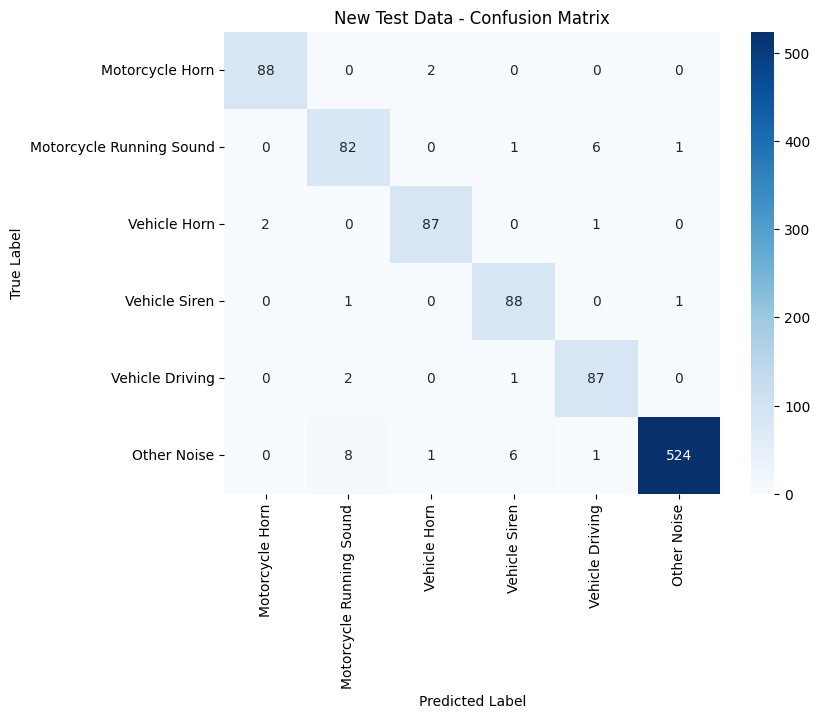


New Test Data Evaluation:
 Accuracy: 0.9657

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.98      0.98      0.98        90
Motorcycle Running Sound       0.88      0.91      0.90        90
            Vehicle Horn       0.97      0.97      0.97        90
           Vehicle Siren       0.92      0.98      0.95        90
         Vehicle Driving       0.92      0.97      0.94        90
             Other Noise       1.00      0.97      0.98       540

                accuracy                           0.97       990
               macro avg       0.94      0.96      0.95       990
            weighted avg       0.97      0.97      0.97       990


--- Sample Predictions ---
1/1 [==============================] - 0s 29ms/step
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [==============================] - 0s 33ms/step
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [========

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################################
# Part 0. 모델 로드 및 데이터 로드
#############################################
model_file = "resnet_model_modified_v4.h5"
test_file = "final_test_sampled_90_category_03.csv"  # 새로운 테스트 데이터 파일 경로를 여기에 입력하세요.

loaded_model = load_model(model_file)
test_df = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩 (학습 데이터와 동일한 라벨 매핑 사용)
#############################################
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

y_test = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 평가 함수 정의 및 적용 (영어 라벨 표시)
#############################################
def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels))
    return acc

# 평가: 테스트 데이터 평가
test_acc = evaluate_model(loaded_model, X_test, y_test, dataset_name="New Test Data")

#############################################
# Part 4. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(loaded_model.predict(X_test[i:i+1]))]
    conf = np.max(loaded_model.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")

### 2) V6 - category3 기준 샘플링 데이터 학습 모델

X_test shape: (990, 50, 1)
31/31 [==============================] - 1s 14ms/step


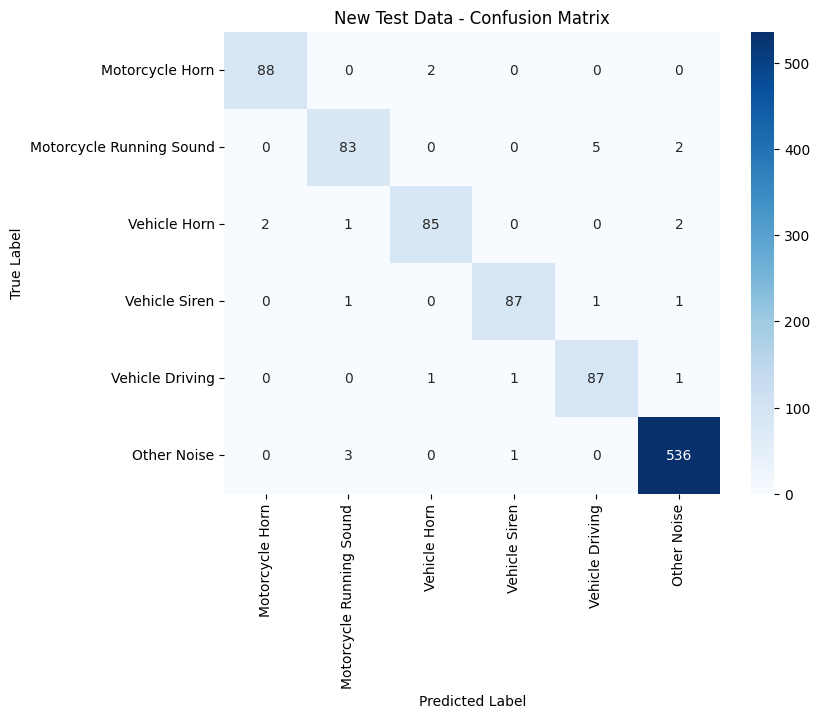


New Test Data Evaluation:
 Accuracy: 0.9758

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.98      0.98      0.98        90
Motorcycle Running Sound       0.94      0.92      0.93        90
            Vehicle Horn       0.97      0.94      0.96        90
           Vehicle Siren       0.98      0.97      0.97        90
         Vehicle Driving       0.94      0.97      0.95        90
             Other Noise       0.99      0.99      0.99       540

                accuracy                           0.98       990
               macro avg       0.96      0.96      0.96       990
            weighted avg       0.98      0.98      0.98       990


--- Sample Predictions ---
1/1 [==============================] - 0s 32ms/step
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [==============================] - 0s 32ms/step
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [========

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################################
# Part 0. 모델 로드 및 데이터 로드
#############################################
model_file = "resnet_model_modified_v6.h5"
test_file = "final_test_sampled_90_category_03.csv"  # 새로운 테스트 데이터 파일 경로를 여기에 입력하세요.

loaded_model = load_model(model_file)
test_df = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩 (학습 데이터와 동일한 라벨 매핑 사용)
#############################################
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

y_test = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 평가 함수 정의 및 적용 (영어 라벨 표시)
#############################################
def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels))
    return acc

# 평가: 테스트 데이터 평가
test_acc = evaluate_model(loaded_model, X_test, y_test, dataset_name="New Test Data")

#############################################
# Part 4. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(loaded_model.predict(X_test[i:i+1]))]
    conf = np.max(loaded_model.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")

### 3) V7 - 원본 데이터 학습 모델

X_test shape: (990, 50, 1)
31/31 [==============================] - 0s 7ms/step


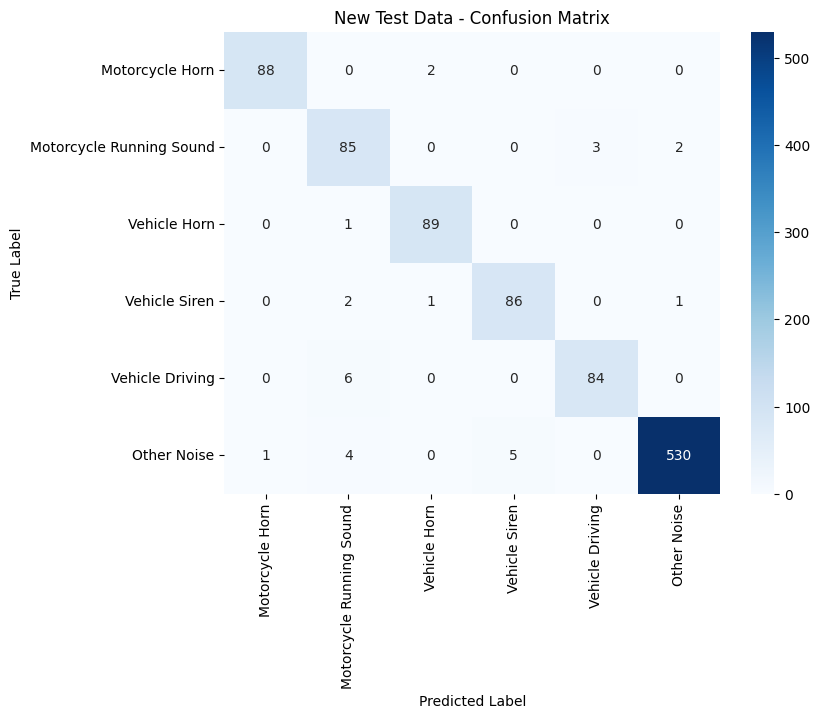


New Test Data Evaluation:
 Accuracy: 0.9717

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.99      0.98      0.98        90
Motorcycle Running Sound       0.87      0.94      0.90        90
            Vehicle Horn       0.97      0.99      0.98        90
           Vehicle Siren       0.95      0.96      0.95        90
         Vehicle Driving       0.97      0.93      0.95        90
             Other Noise       0.99      0.98      0.99       540

                accuracy                           0.97       990
               macro avg       0.95      0.96      0.96       990
            weighted avg       0.97      0.97      0.97       990


--- Sample Predictions ---
1/1 [==============================] - 0s 18ms/step
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [==============================] - 0s 17ms/step
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [========

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################################
# Part 0. 모델 로드 및 데이터 로드
#############################################
model_file = "resnet_model_modified_v7.h5"
test_file = "final_test_sampled_90_category_03.csv"  # 새로운 테스트 데이터 파일 경로를 여기에 입력하세요.

loaded_model = load_model(model_file)
test_df = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩 (학습 데이터와 동일한 라벨 매핑 사용)
#############################################
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

y_test = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 평가 함수 정의 및 적용 (영어 라벨 표시)
#############################################
def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels))
    return acc

# 평가: 테스트 데이터 평가
test_acc = evaluate_model(loaded_model, X_test, y_test, dataset_name="New Test Data")

#############################################
# Part 4. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(loaded_model.predict(X_test[i:i+1]))]
    conf = np.max(loaded_model.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")

## 3. ood 샘플링 테스트 파일

### 1) V4 - ood 기준 샘플링 데이터 학습 모델

X_test shape: (1320, 50, 1)
42/42 [==============================] - 1s 13ms/step


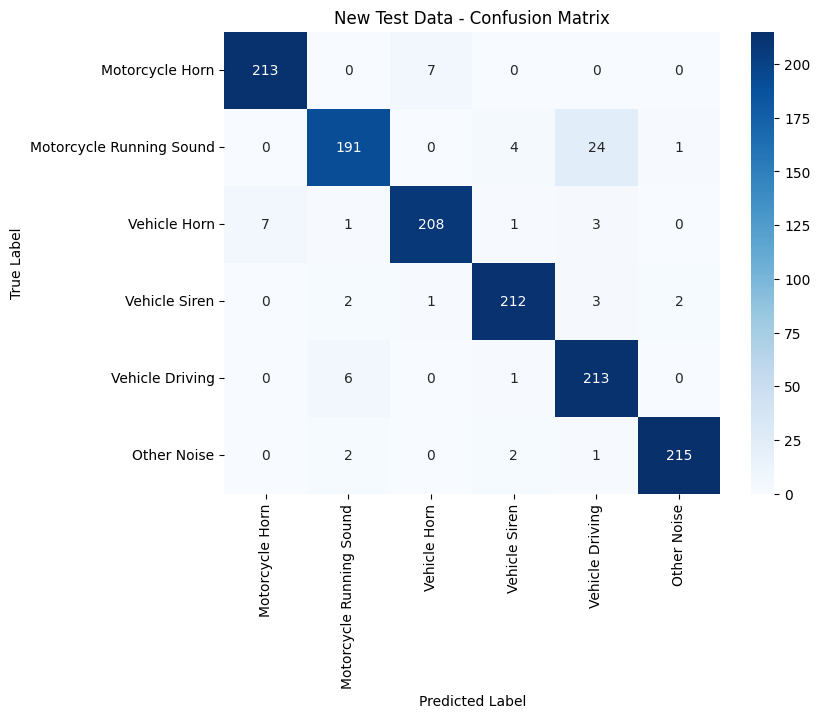


New Test Data Evaluation:
 Accuracy: 0.9485

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.97      0.97      0.97       220
Motorcycle Running Sound       0.95      0.87      0.91       220
            Vehicle Horn       0.96      0.95      0.95       220
           Vehicle Siren       0.96      0.96      0.96       220
         Vehicle Driving       0.87      0.97      0.92       220
             Other Noise       0.99      0.98      0.98       220

                accuracy                           0.95      1320
               macro avg       0.95      0.95      0.95      1320
            weighted avg       0.95      0.95      0.95      1320


--- Sample Predictions ---
1/1 [==============================] - 0s 29ms/step
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 0.9979
1/1 [==============================] - 0s 34ms/step
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [========

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################################
# Part 0. 모델 로드 및 데이터 로드
#############################################
model_file = "resnet_model_modified_v4.h5"
test_file = "final_test_data_sampled_220_ood_label.csv"  # 새로운 테스트 데이터 파일 경로를 여기에 입력하세요.

loaded_model = load_model(model_file)
test_df = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩 (학습 데이터와 동일한 라벨 매핑 사용)
#############################################
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

y_test = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 평가 함수 정의 및 적용 (영어 라벨 표시)
#############################################
def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels))
    return acc

# 평가: 테스트 데이터 평가
test_acc = evaluate_model(loaded_model, X_test, y_test, dataset_name="New Test Data")

#############################################
# Part 4. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(loaded_model.predict(X_test[i:i+1]))]
    conf = np.max(loaded_model.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")

### 2) V6 - category3 기준 샘플링 데이터 학습 모델

X_test shape: (1320, 50, 1)
42/42 [==============================] - 1s 13ms/step


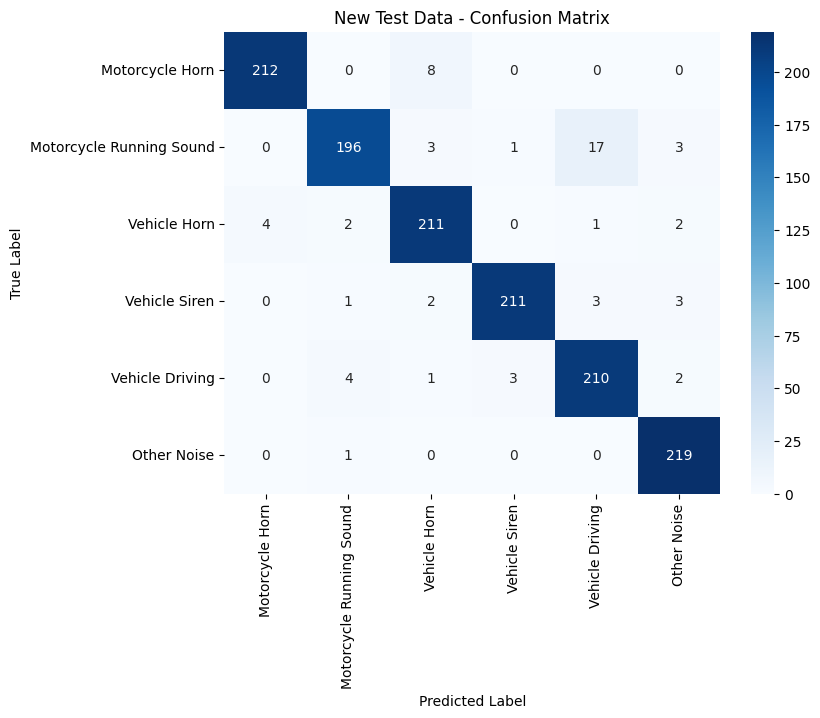


New Test Data Evaluation:
 Accuracy: 0.9538

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.98      0.96      0.97       220
Motorcycle Running Sound       0.96      0.89      0.92       220
            Vehicle Horn       0.94      0.96      0.95       220
           Vehicle Siren       0.98      0.96      0.97       220
         Vehicle Driving       0.91      0.95      0.93       220
             Other Noise       0.96      1.00      0.98       220

                accuracy                           0.95      1320
               macro avg       0.95      0.95      0.95      1320
            weighted avg       0.95      0.95      0.95      1320


--- Sample Predictions ---
1/1 [==============================] - 0s 36ms/step
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [==============================] - 0s 49ms/step
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [========

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################################
# Part 0. 모델 로드 및 데이터 로드
#############################################
model_file = "resnet_model_modified_v6.h5"
test_file = "final_test_data_sampled_220_ood_label.csv"  # 새로운 테스트 데이터 파일 경로를 여기에 입력하세요.

loaded_model = load_model(model_file)
test_df = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩 (학습 데이터와 동일한 라벨 매핑 사용)
#############################################
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

y_test = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 평가 함수 정의 및 적용 (영어 라벨 표시)
#############################################
def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels))
    return acc

# 평가: 테스트 데이터 평가
test_acc = evaluate_model(loaded_model, X_test, y_test, dataset_name="New Test Data")

#############################################
# Part 4. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(loaded_model.predict(X_test[i:i+1]))]
    conf = np.max(loaded_model.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")

### 3) V7 - 원본 데이터 학습 모델

X_test shape: (1320, 50, 1)
42/42 [==============================] - 1s 7ms/step


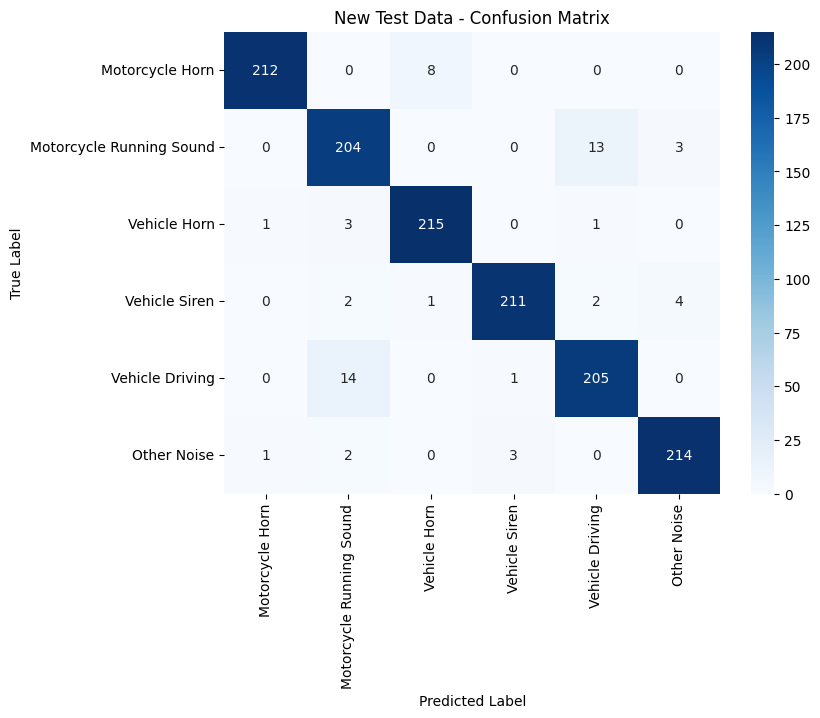


New Test Data Evaluation:
 Accuracy: 0.9553

Classification Report:
                           precision    recall  f1-score   support

         Motorcycle Horn       0.99      0.96      0.98       220
Motorcycle Running Sound       0.91      0.93      0.92       220
            Vehicle Horn       0.96      0.98      0.97       220
           Vehicle Siren       0.98      0.96      0.97       220
         Vehicle Driving       0.93      0.93      0.93       220
             Other Noise       0.97      0.97      0.97       220

                accuracy                           0.96      1320
               macro avg       0.96      0.96      0.96      1320
            weighted avg       0.96      0.96      0.96      1320


--- Sample Predictions ---
1/1 [==============================] - 0s 18ms/step
Sample 0: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [==============================] - 0s 18ms/step
Sample 1: True = 기타소음, Predicted = 기타소음, Confidence = 1.0000
1/1 [========

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################################
# Part 0. 모델 로드 및 데이터 로드
#############################################
model_file = "resnet_model_modified_v7.h5"
test_file = "final_test_data_sampled_220_ood_label.csv"  # 새로운 테스트 데이터 파일 경로를 여기에 입력하세요.

loaded_model = load_model(model_file)
test_df = pd.read_csv(test_file)

#############################################
# Part 1. 라벨 매핑 및 인코딩 (학습 데이터와 동일한 라벨 매핑 사용)
#############################################
final_labels = ['이륜차경적', '이륜차주행음', '차량경적', '차량사이렌', '차량주행음', '기타소음']
english_labels = ['Motorcycle Horn', 'Motorcycle Running Sound', 'Vehicle Horn', 'Vehicle Siren', 'Vehicle Driving', 'Other Noise']

label_to_code = {label: i for i, label in enumerate(final_labels)}
unknown_label_index = label_to_code['기타소음']

if 'ood_label' in test_df.columns:
    test_df['encoded_label'] = test_df['ood_label'].map(lambda x: label_to_code.get(x, unknown_label_index))
else:
    raise ValueError("테스트 데이터에 'ood_label' 컬럼이 없습니다.")

y_test = test_df['encoded_label'].values

#############################################
# Part 2. 입력 데이터 준비 (MFCC)
#############################################
mfcc_columns = [f"mfcc_{i}" for i in range(1, 51)]
X_test = test_df[mfcc_columns].values

# Reshape: (samples, 50) -> (samples, 50, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)

#############################################
# Part 3. 평가 함수 정의 및 적용 (영어 라벨 표시)
#############################################
def evaluate_model(model, X, y_true, dataset_name="Test"):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=english_labels, yticklabels=english_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()

    print(f"\n{dataset_name} Evaluation:")
    print(f" Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=english_labels))
    return acc

# 평가: 테스트 데이터 평가
test_acc = evaluate_model(loaded_model, X_test, y_test, dataset_name="New Test Data")

#############################################
# Part 4. 일부 샘플 예측 결과 출력
#############################################
print("\n--- Sample Predictions ---")
index_to_label = {v: k for k, v in label_to_code.items()}
for i in range(10):
    true_lbl = index_to_label[y_test[i]]
    pred_lbl = index_to_label[np.argmax(loaded_model.predict(X_test[i:i+1]))]
    conf = np.max(loaded_model.predict(X_test[i:i+1]))
    print(f"Sample {i}: True = {true_lbl}, Predicted = {pred_lbl}, Confidence = {conf:.4f}")